In [1]:
# First of all, Importing the important libraries
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree, datasets
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

## 7. In the lab, we applied random forests to the Boston data using mtry=6 and using ntree=25 and ntree=500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for mtry and ntree. You can model your plot after Figure 8.10. Describe the results obtained.

In [94]:
# Load the boston dataset.
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']],
                         columns= [c for c in boston_df['feature_names']] + ['Price'])

display(boston_df.head())

# Create design and response matrix
f = 'Price ~ ' + ' + '.join(boston_df.columns.drop(['Price']))
y, X = pt.dmatrices(f, boston_df, return_type='dataframe')


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.50)

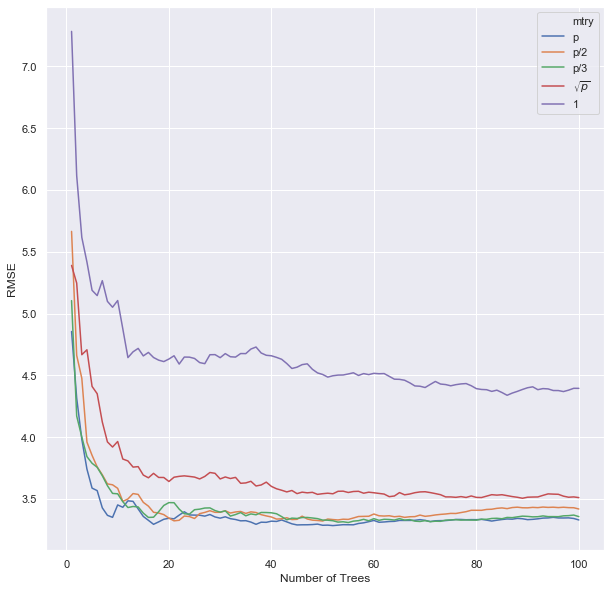

In [96]:
# Compare test RMSE of Random Forest for various numbers of features considered at each split (mtry)
# and increasing number of trees (ntree)

max_features = {'p': X.shape[1], 
                'p/2': int(np.around(X.shape[1]/2)),
                'p/3': int(np.around(X.shape[1]/3)),
                '$\sqrt{p}$': int(np.around(np.sqrt(X.shape[1]))),
                '1': 1}

results = []
for mtry in max_features:
    for tree_count in range(1, 101):
        rfr   = RandomForestRegressor(max_features=max_features[mtry], random_state=0, n_estimators=tree_count)
        rfr.fit(X_train, y_train)
        pred = rfr.predict(X_test)
        
        mse = metrics.mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        results += [[tree_count, mtry, rmse]]

plt.figure(figsize=(10,10))
sns.lineplot(x='Number of Trees', y='RMSE', hue='mtry', 
             data=pd.DataFrame(results, columns=['Number of Trees', 'mtry', 'RMSE']));

**Coments:**
- The above shows the test RMSE for a 50% holdout set where training set contains 240 observations each with 14 predictors.

- We find that the test RMSE decreases with increasing number of trees for all values of mtry (number of random features considered at each split)

- The optimal value of m is less than p and greater than 1. In this case $m=\sqrt{p}$ yields the best results for $ntree>?$ although $p/2$ performs better for some lower tree counts.

- Incredibly the model does not seem prone to overfitting with test RMSE continuing to decrees up to ntree = 100.

## 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.
### (a) Split the data set into a training set and a test set.
### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [97]:
carseats_df = pd.read_csv('./Data_sets/Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0
# Drop unused index
carseats_df = carseats_df.drop('Unnamed: 0', axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.50)

display(carseats_df.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [98]:
carseats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null object
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null object
US             400 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [99]:
# Use all features excpet response features
# No intercept

preds = carseats_df.columns.drop(['Sales'])
#preds_scaled = ['standardize({})'.format(p) for p in preds]
f = 'Sales ~ 0 +' + ' + '.join(preds)
y, X = pt.dmatrices(f, carseats_df, return_type='dataframe')

# Fit Sklearn's tree regressor
dtr = tree.DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

# Measure test set MSE
pred = dtr.predict(X_test)
mse = metrics.mean_squared_error(y_test, pred)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

Test MSE: 22.886
Test RMSE: 4.784


### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

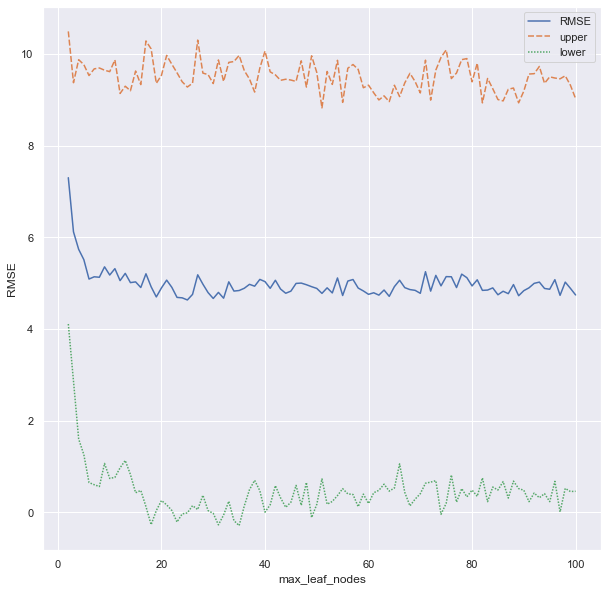

,RMSE,upper,lower
max_leaf_nodes,,,
25.0,4.631312,9.277281,-0.014656


Test MSE : 24.428
Test RMSE: 4.942


In [100]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_leaf_nodes parameter?

cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']

results = []
for m in np.arange(2, 101):
    dtr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    cv_scores = cross_val_score(dtr, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(cv_scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# Use chosen model for test prediction
dtr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X_train, y_train)
pred = dtr.predict(X_test)
mse = metrics.mean_squared_error(y_test, pred)

# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

- 10-fold cross validation selects a pruned tree model that achieves test MSE of 4.832, an improvement on the unpruned model (5.495). Interestingly 100-fold, 5-fold and 2-fold CV were all unable to select an improvement on the unpruned model.

### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [101]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

n_predictors = X.shape[1]
max_features = n_predictors
tree_count   = 100

rfr   = RandomForestRegressor(max_features= max_features,
                              random_state= 0,
                              n_estimators= tree_count)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 9.85
Test RMSE: 3.139


In [102]:
rfr.feature_importances_

array([0.        , 0.07382689, 0.0011411 , 0.01101548, 0.00163549,
       0.0291965 , 0.30367329, 0.01295369, 0.05349133, 0.00367868,
       0.0210088 , 0.01360791, 0.01648113, 0.45828971])

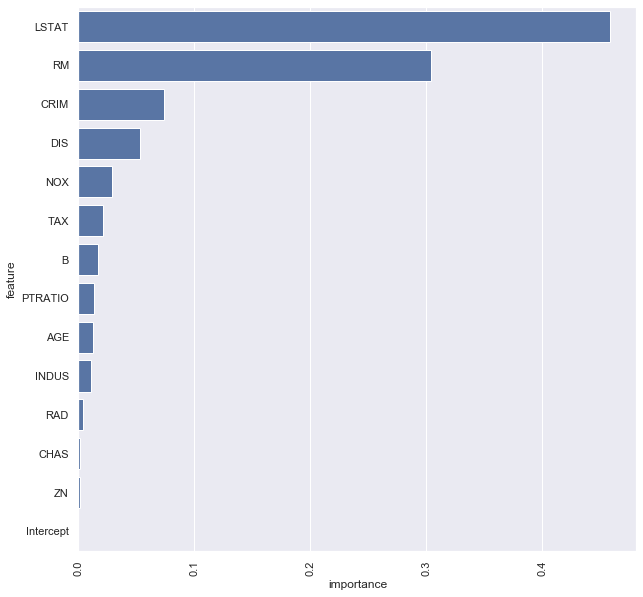

In [103]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X_train.columns, 'importance': rfr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

- Bagging yields a significantly improved test **MSE** of **2.757** compared with **4.832** for the optimal pruned tree.


- The bagging model indicates that instore **Shelve Location (Good)** and **Price** of the carseat are the most significant features affecting Sales revenue. This aligns with our observation when performing classification in hte lab.

### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [104]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 7
tree_count   = 100

rfr   = RandomForestRegressor(max_features=max_features,
                              random_state=0,
                              n_estimators=tree_count)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 9.674
RMSE test: 3.11


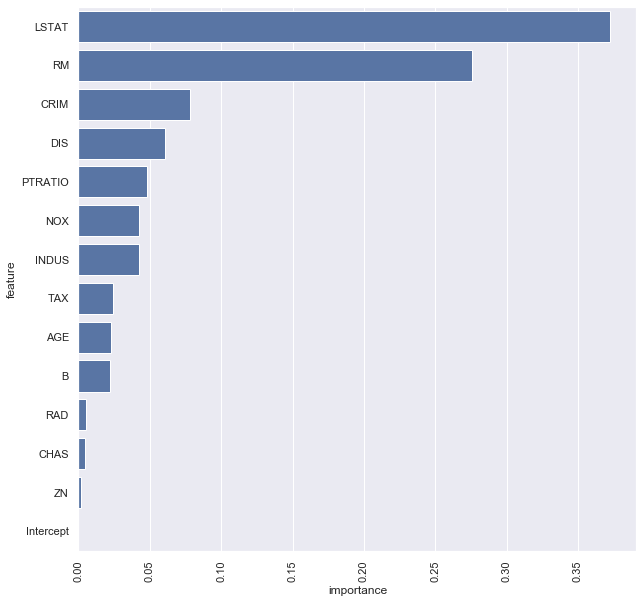

In [105]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X_train.columns, 'importance': rfr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

- Random forest with 7 predictors at each split yields a test MSE **2.844** similar to bagging **2.757**. A similar feature importance is ascribed **['Shelve Location (Good)' and 'Price']**.

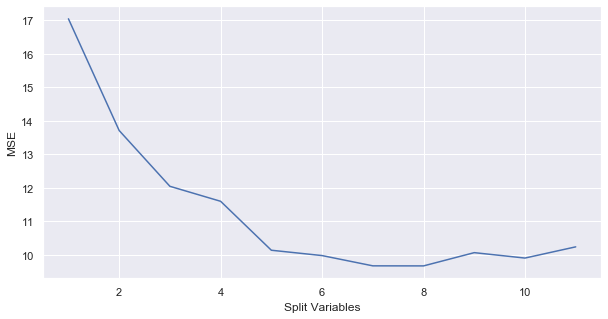

In [106]:
# Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

results = []
for max_features in range(1, X.shape[1]):

    tree_count   = 100
    
    rfr   = RandomForestRegressor(max_features=max_features,
                                  random_state=0,
                                  n_estimators=tree_count)
    rfr.fit(X_train, y_train)
    pred = rfr.predict(X_test)
    
    mse = metrics.mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    
    results += [[max_features, mse]]

plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']));

## 9. This problem involves the OJ data set which is part of the ISLR package.
### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

### (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [131]:
oj_df = pd.read_csv('./Data_sets/oj.csv')
oj_df = oj_df.drop(oj_df.columns[0], axis=1)

oj_df.Purchase = oj_df.Purchase.map({'CH' : 1, 'MM': 0})
oj_df.Store7 = oj_df.Store7.map({'Yes' : 1, 'No': 0})

display(oj_df.info())
display(oj_df.head())


# Split the data for Training set of 800, with Purchase as the response
# and the other varibles as predictors.
X_train, X_test, y_train, y_test = train_test_split( oj_df.drop('Purchase', axis=1), oj_df['Purchase'],
                                                    test_size=0.25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
Purchase          1070 non-null int64
WeekofPurchase    1070 non-null int64
StoreID           1070 non-null int64
PriceCH           1070 non-null float64
PriceMM           1070 non-null float64
DiscCH            1070 non-null float64
DiscMM            1070 non-null float64
SpecialCH         1070 non-null int64
SpecialMM         1070 non-null int64
LoyalCH           1070 non-null float64
SalePriceMM       1070 non-null float64
SalePriceCH       1070 non-null float64
PriceDiff         1070 non-null float64
Store7            1070 non-null int64
PctDiscMM         1070 non-null float64
PctDiscCH         1070 non-null float64
ListPriceDiff     1070 non-null float64
STORE             1070 non-null int64
dtypes: float64(11), int64(7)
memory usage: 150.6 KB


None

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,1,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,0,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,1,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


In [125]:
# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)

print('training accuracy: {}'.format(np.around(clf.score(X_train, y_train), 3)))
print('leaf nodes: 6')

training accuracy: 0.991
leaf nodes: 6


### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.
### (d) Create a plot of the tree, and interpret the results.

In [126]:
# Installing the path of Graphviz
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [127]:
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns, 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [128]:
# Here's the confusion matrix
print(confusion_matrix(y_test, clf.predict(X_test)))

test_err = 1 - clf.score(X_test, y_test)
print('\ntest error rate: {}'.format(np.around(test_err, 3)))

[[ 74  39]
 [ 37 118]]

test error rate: 0.284


### (f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.
### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.
### (h) Which tree size corresponds to the lowest cross-validated classification error rate?

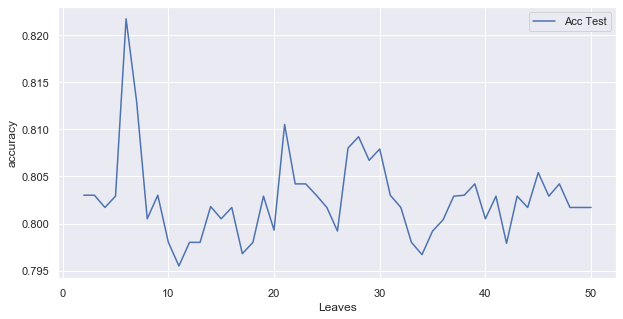

,Acc Test
Leaves,
6.0,0.8217


In [132]:
# Estimate optimal tree with cross validation on training set

cv_folds = 10

results = []
for m in np.arange(2, 51):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=m)
    CV_scores = cross_val_score(clf, X_train, y_train, cv=cv_folds)
    rmse = np.mean(CV_scores)
    results += [[m, round(rmse, 4)]]


plt.figure(figsize=(10,5))
plot_df = pd.DataFrame(np.asarray(results), columns=['Leaves', 'Acc Test']).set_index('Leaves')
sns.lineplot(data=plot_df);
plt.ylabel('accuracy')
plt.show();

display(HTML('<h4>Optimal tree size:</h4>'))
display(plot_df[plot_df['Acc Test'] == plot_df['Acc Test'].max()])

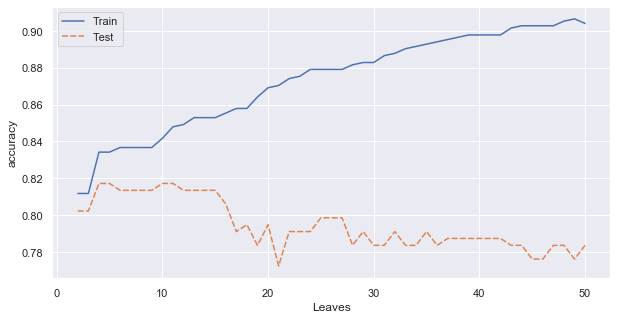

,Train,Test
Leaves,,
4.0,0.834165,0.817164
5.0,0.834165,0.817164
10.0,0.841646,0.817164
11.0,0.847880,0.817164


In [138]:
# Determine actual optimal tree using test set.

results = []
for m in np.arange(2, 51):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=m).fit(X_train, y_train)

    Acc_train = clf.score(X_train, y_train)  
    Acc_test = clf.score(X_test, y_test)  
    results += [[m, Acc_train, Acc_test]]

plt.figure(figsize=(10,5))
plot_df = pd.DataFrame(np.asarray(results), columns=['Leaves', 'Train', 'Test']).set_index('Leaves')
sns.lineplot(data=plot_df);
plt.ylabel('accuracy')
plt.show();

display(HTML('<h4>Optimal tree size:</h4>'))
display(plot_df[(plot_df['Test'] == plot_df['Test'].max())])

### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.
### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?
### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

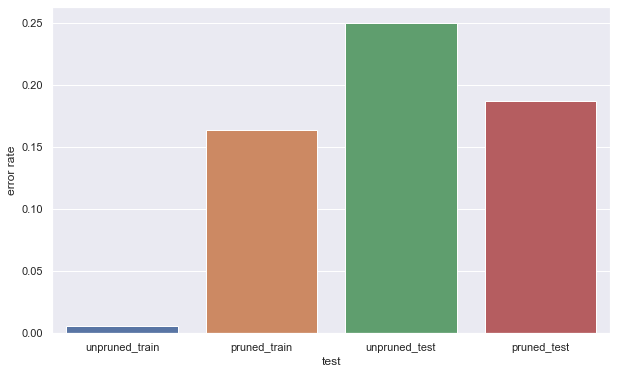

,test,error rate
0,unpruned_train,0.0062
1,pruned_train,0.1633
2,unpruned_test,0.2500
3,pruned_test,0.1866


In [145]:
clf_unpruned = tree.DecisionTreeClassifier().fit(X_train, y_train)
clf_pruned   = tree.DecisionTreeClassifier(max_leaf_nodes=6).fit(X_train, y_train)

scores = [['unpruned_train', 1 - round(clf_unpruned.score(X_train, y_train), 4)],
          ['pruned_train', 1 - round(clf_pruned.score(X_train, y_train), 4)],
          ['unpruned_test', 1 - round(clf_unpruned.score(X_test, y_test), 4)],
          ['pruned_test', 1 - round(clf_pruned.score(X_test, y_test), 4)]]

plot_df = pd.DataFrame(scores, columns=['test', 'error rate'])

plt.figure(figsize=(10, 6))
sns.barplot(x='test', y='error rate', data=plot_df)
plt.show();

display(plot_df)

- The unpruned tree performs best in the training setting where as the pruned tree performs best in the test setting. This suggests that the unpruned tree is **overfitting** the training data leading to poor test score.

## 10. We now use boosting to predict Salary in the Hitters data set.
### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [205]:
hitters_df = pd.read_csv('./Data_sets/Hitters.csv')

# Drop null observations
hitters_df = hitters_df.dropna()
assert hitters_df.isnull().sum().sum() == 0

f = 'np.log(Salary) ~ ' + ' + '.join(hitters_df.columns.drop(['Salary']))
y, X = pt.dmatrices(f, hitters_df, return_type='dataframe')

display(X.head())

,Intercept,League[T.N],Division[T.W],NewLeague[T.N],AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,1.0,1.0,1.0,1.0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0
2,1.0,0.0,1.0,0.0,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0
3,1.0,1.0,0.0,1.0,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0
4,1.0,1.0,0.0,1.0,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0
5,1.0,0.0,1.0,0.0,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0


### (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [206]:
# Splitting the data set
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.23)

### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.
### (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

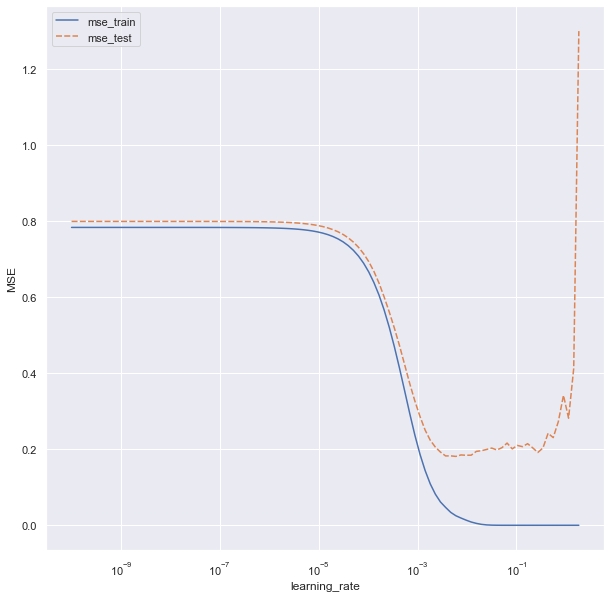

,mse_train,mse_test
learning_rate,,
0.00595,0.025117,0.181301


In [207]:
# Gradient boosting

max_features = 'auto'
tree_count   = 1000

results = []
for learning_rate in np.logspace(-10, np.log(1.3), 100): 
    regr   = GradientBoostingRegressor(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)
    regr = regr.fit(X_train, y_train)
    pred_train = regr.predict(X_train)
    pred_test  = regr.predict(X_test)
    
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    mse_test  = metrics.mean_squared_error(y_test, pred_test)
    
    results += [[learning_rate, mse_train, mse_test]]

# Plot
plot_df = pd.DataFrame(np.asarray(results), 
                  columns=['learning_rate', 'mse_train', 'mse_test']).set_index('learning_rate')
plt.figure(figsize=(10,10))
ax  = sns.lineplot(data=plot_df)
ax.set_xscale('log')
plt.ylabel('MSE')
plt.show();

# Show best learning rate
display(plot_df[plot_df['mse_test'] == plot_df['mse_test'].min()])

### (e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [208]:
# Naive ols
model = sm.OLS(y_train, X_train).fit()
pred = model.predict(X_test)

mse_test = metrics.mean_squared_error(y_test, pred)
print('MSE test: {}'.format(np.around(mse_test, 3)))

MSE test: 0.436


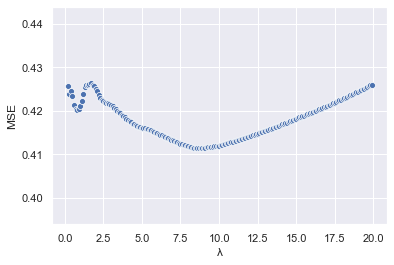

RMSE Train CV: 0.6414101833230021
@Lambda: 8.400000000000002
MSE test: 0.541
RMSE test: 0.736


In [209]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                      normalize=False, positive=False, precompute=False, random_state=0,
                      selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        pred = model.predict(X_test)
        #print(y_test)
        MSEs += [metrics.mean_squared_error(y_test, pred)]
    return MSEs

#X_train = pd.DataFrame(X[train], columns=X.design_info.column_names)
#y_train = pd.DataFrame(y[train], columns=['Price'])

#lambdas = np.arange(.000002, 0.02, .0001)

lambdas = np.arange(0.2, 20, .1)

MSEs    = [] 
for i in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=i, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# Choose model
lamb = min(zip(MSEs, lambdas))
print('RMSE Train CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))


# Use chosen model on test set prediction
model = Lasso(alpha=lamb[1], copy_X=True, fit_intercept=True, max_iter=10000,
              normalize=False, positive=False, precompute=False, random_state=0,
              selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)

pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

**Comment:**

- Boosting yields a test MSE of 0.207, which is significantly better than naive OLS (0.455) and the Lasso (0.469).

- It is interesting that naive OLS with all features outperforms the lasso. This suggests that the lasso is unable to identify redundant features in the model.

### (f) Which variables appear to be the most important predictors in the boosted model?

0.18164752510346102


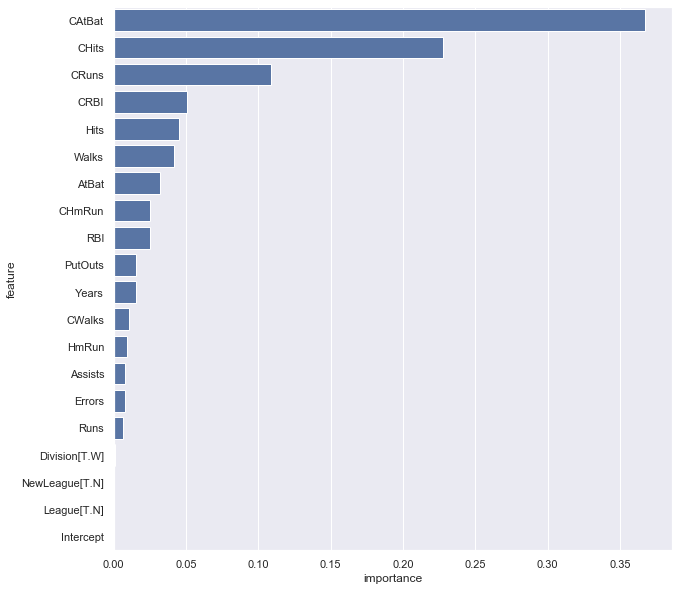

In [213]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.00595

regr = GradientBoostingRegressor(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

regr = regr.fit(X_train, y_train)
pred_test  = regr.predict(X_test)

mse_test  = metrics.mean_squared_error(y_test, pred_test)
print(mse_test)

# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X_train.columns, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=0);

- The boosting model suggests that **CAtBat** – Number of times at bat during his career – is by far the most important predictor of Salary.

- Number of walks during his career (CHits) is also predictive of salary, but it seems likely that this feature would be covariant with CAtBat.

### (g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [216]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X_train.shape[1]
tree_count   = 1000

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 0.192
RMSE test: 0.439


- Bagging achieves a test MSE of 0.208 which is equivalent to that achieved by boosting. Bagging has the advantage here that the result was achived without need to tune hyper-parameters.

## 11. This question uses the Caravan data set.
### (a) Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

In [259]:
caravan_df = pd.read_csv('./Data_sets/Caravan.csv').drop('Unnamed: 0', axis=1)

caravan_df = pd.get_dummies(caravan_df, prefix='Purchase', drop_first=True)
X = caravan_df.drop('Purchase_Yes', axis= 1)
y = caravan_df['Purchase_Yes']
# Now spilt the data set
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.8282)

# Display processed features
display(caravan_df.head())

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase_Yes
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


### (b) Fit a boosting model to the training set with Purchase as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

accuracy: 92.93%


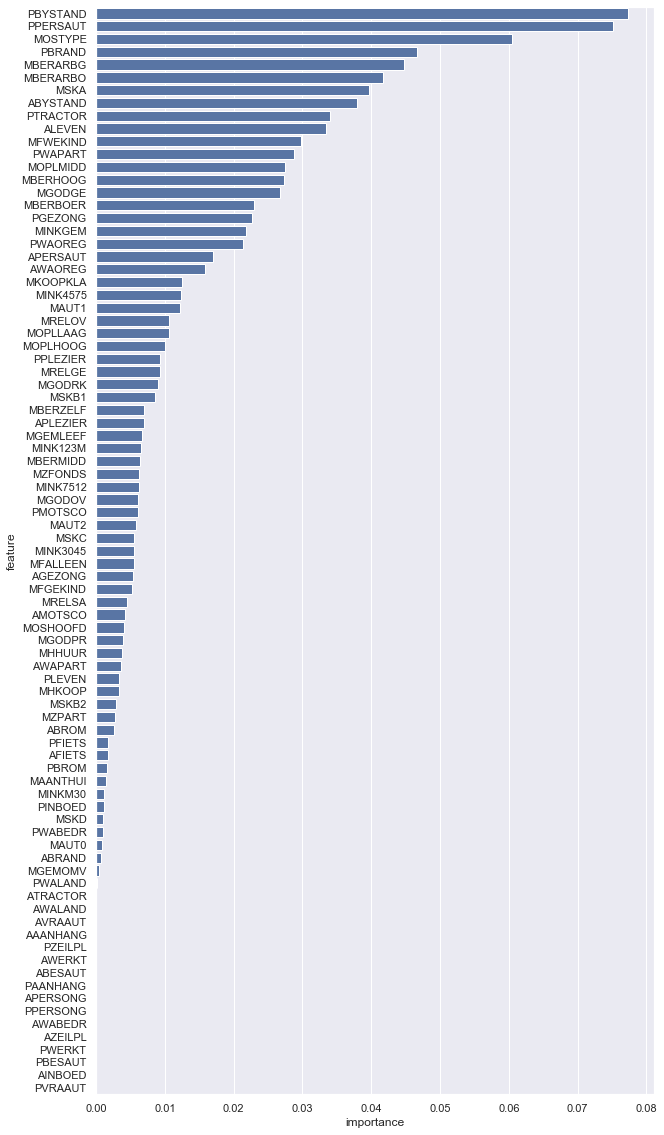

In [266]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.01

model = GradientBoostingClassifier(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

model = model.fit(X_train, y_train)
#pred_test  = regr.predict(X_train)

accuracy = model.score(X_test, y_test)
print('accuracy: {}%'.format(round(accuracy*100, 2)))

# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
plot_df = plot_df.sort_values('importance', ascending=False)
plt.figure(figsize=(10,20))
sns.barplot(x='importance', y='feature', data=plot_df,
            color='b')

In [270]:
# The most important 10 predictors 
plot_df.head(10)

,feature,importance
63,PBYSTAND,0.077239
46,PPERSAUT,0.075178
0,MOSTYPE,0.060434
58,PBRAND,0.046697
22,MBERARBG,0.044782
23,MBERARBO,0.041636
24,MSKA,0.039617
84,ABYSTAND,0.037992
51,PTRACTOR,0.034027
75,ALEVEN,0.033375


Here we use boosting to predict if someone purchases caravan insurance, a classification problem. The boosting model yields a test set prediction accuracy of 92.93%.

The model suggests that the ten most important predictors are:

- PPLEIZER: Contribution boat policies
- ALEVAN: Number of life insurances
- PBRAND: Contribution fire policies
- MOSTYPE: Customer Subtype; see L0
- MBERARBG: Skilled labourers
- APERSAUT: Number of car policies
- AFIETS: Number of bicycle policies
- MRELGE: Married
- MGEMLEEF: Avg age
- MFWEKIND: Household with children
Broadly these predictors indicate whether customer has other insurance policies, and their level of family commitment e.g. married, with children.

We can't tell the direction in which these predictors are related with reposnse Revision note: is this possible in the boosting setting?

From tnis might hypothesise that customers who have already purchased insurance of other kinds are more inclined to purchase caravan insurance. Also, those with more family commitment and responsibility might also be more inclined to purchase insurance. It seems plausible that these two groups are more risk averse.

### (c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [277]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.01

model = GradientBoostingClassifier(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

model = model.fit(X_train, y_train)
#y_hat_test  = regr.predict(X[~train])


# Boosting stats
threshold = 0.2
pred_proba = model.predict_proba(X_test)
pred = (pred_proba[:, 1] > threshold).astype(np.float64)
confusion_mat = confusion_matrix(y_test, pred)

# What fraction of the people predicted to make a purchase do in fact make one?
pos_pred_val = round(confusion_mat[:, 1][1] / np.sum(confusion_mat[:, 1]), 4)

display(HTML('<h4>BOOSTING: Confusion matrix</h4>'))
print(confusion_mat)

print('\nPositive Predictive Value: {}%'.format(pos_pred_val*100))

[[4328  204]
 [ 241   49]]

Positive Predictive Value: 19.37%


In [279]:
# KNN

# PREDICT
for K in range(1, 10):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
    # Predict
    pred = model.predict(X_test)
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, pred)
    print(confusion_mtx)
    
    ## Classifier stats
    pos_pred_val = np.around(confusion_mtx[:, 1][1] / np.sum(confusion_mtx[:, 1 ]), 4)
    print('\nPositive Predictive Value: {}%'.format(pos_pred_val*100))

[[4301  231]
 [ 260   30]]

Positive Predictive Value: 11.49%


[[4528    4]
 [ 288    2]]

Positive Predictive Value: 33.33%


[[4508   24]
 [ 280   10]]

Positive Predictive Value: 29.409999999999997%


[[4529    3]
 [ 289    1]]

Positive Predictive Value: 25.0%


[[4525    7]
 [ 284    6]]

Positive Predictive Value: 46.150000000000006%


[[4532    0]
 [ 290    0]]

Positive Predictive Value: nan%


[[4532    0]
 [ 289    1]]

Positive Predictive Value: 100.0%


[[4532    0]
 [ 290    0]]

Positive Predictive Value: nan%


[[4528    4]
 [ 290    0]]

Positive Predictive Value: 0.0%


**Comment:** 
- KNN performs best when k=5 achieving a Positive Predictive Value of 0.461, which is slightly worse but not disimilar to the boosting result (0.205). The boosting model also excels in achieving roughly 8 times more True Positive predictions, so we would certainly choose the boosting model in this case.


- It is worth noting that the dataset in this setting is highly dimensional with over 80 predictors, so the effectiveness of KNN is likely hindered by the curse of dimensionality.

## 12. Apply boosting, bagging, and random forests to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?
# TODO:

# Done!